In [11]:
# Program to generate exploratory data analysis for data incubator challenge/project

# Import relevant modules
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize

# Merge the data
data_folder=os.path.join(os.getcwd())
turnstile_file='Turnstile_Usage_Data__2018_A.csv'
turnstile_columns=['C/A','Unit','Station','Line Name','Date','Time','Entries','Exits'] # Dont' read all data
subway_location_file='NYC_Transit_Subway_Entrance_And_Exit_Data.csv'
subway_location_columns=['Station Name','Line','Station Latitude','Station Longitude']

# Ok, read data
filename=os.path.join(data_folder,turnstile_file)
#data=pd.read_csv(filename,parse_dates=['Date','Time'],infer_datetime_format=True,usecols=turnstile_columns)
# Is regular reading faster?
data=pd.read_csv(filename,parse_dates=['Date','Time'],infer_datetime_format=True)
filename=os.path.join(data_folder,subway_location_file)
subway_locations=pd.read_csv(filename,usecols=subway_location_columns)
subway_locations=subway_locations.drop_duplicates(['Station Name','Station Latitude','Station Longitude'])
subway_locations=subway_locations.reset_index()
    # Remove duplicates and reset index
subway_locations.loc[:,'Station Name']=subway_locations.loc[:,'Station Name'].str.upper()
    # To match data
    


In [12]:
# Ok, we need to do some cleaning up to get geocodes... use fuzzywuzzy to match strings?
from fuzzywuzzy import fuzz, process

# Now, append latitude and longitude data
for count,value in enumerate(data.Station.unique()):
    extract_best_station=process.extractOne(value,subway_locations['Station Name'])
    
    # Only fill data if it's a good match
    if extract_best_station[1]>90:
        idx=data.Station==value # Find all samples from this station
        idx_sub=subway_locations.loc[:,'Station Name']==extract_best_station[0]
        
        tempval=np.array(subway_locations.loc[idx_sub,'Station Latitude'])
        data.loc[idx,'Latitude']=tempval[0]
        tempval=np.array(subway_locations.loc[idx_sub,'Station Longitude'])
        data.loc[idx,'Longitude']=tempval[0]

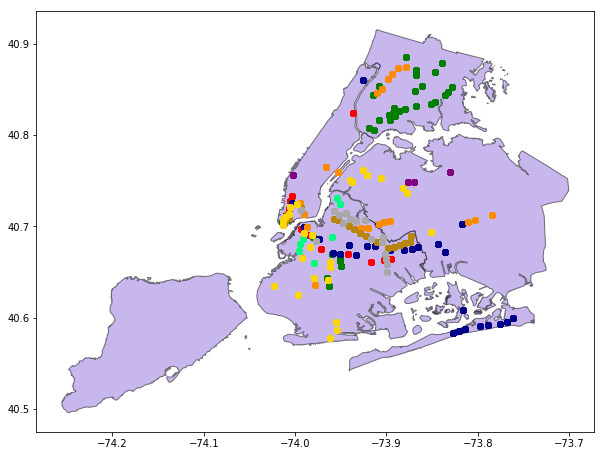

In [22]:
# Ok, now let's group according to line
subway_lines=np.array(['123','456','7','ACE','BDFM','G','JZ','L','NWRQ'])
plotColor=np.array(['red','green','purple','darkblue','darkorange','springgreen','darkgoldenrod','darkgrey','gold'])

# Do a scatter plot of where the stations are 
#plt.figure()
# Let's create a base map with geopandas
import geopandas as gpd
#import descartes
from shapely.geometry import Point #, Polygon
#import shapely.wkt

nymap=gpd.read_file(gpd.datasets.get_path('nybb'))
nymap=nymap.to_crs(epsg=4326) # Convert to lat/long coordinates
ax=nymap.plot(figsize=(10,10),alpha=0.5,edgecolor='k',color='mediumpurple')

for count,value in enumerate(subway_lines):
    for i in range(len(value)):
        tempi=data['Line Name'].str.contains(value[i])
        if i==0:
            idx=tempi
        else:
            idx=idx | tempi
   
    # Get rid of nans
    idx2=data.Latitude.notnull()
    
    idx=idx2 & idx
    
    # Plt
    xval=data.loc[idx,'Latitude']
    yval=data.loc[idx,'Longitude']
    size1=data.loc[idx,'Entries']
    size2=data.loc[idx,'Exits']
    # Now create points to project onto map
    geometry = [Point(x,y) for x,y in zip(yval,xval)]
    #geometry[:3]
    #geometry = geometry.to_crs(nymap.crs)
    # Create geodataframe
    #geo_df, geometry=gpd.points_from_xy(xval,yval)
    geo_df=gpd.GeoDataFrame(data.loc[idx,:],crs=nymap.crs,geometry=geometry)
    # Remove string issue
    #geo_df['geometry']=geo_df['geometry'].apply(shapely.wkt.loads)
    geo_df.plot(ax=ax,color=plotColor[count],alpha=0.5,marker='o',label=value)
    #plt.scatter(xval,yval,color=plotColor[count],alpha=0.5)
    #ax2.scatter(xval,yval,color=plotColor[count],s=size12)
    
    


## Plot above shows that distribution of busy stations across NYC color-coded to their subway lines

## Busy hotspots are downtown, the Bronx and in Queens
                         